# Initial training of the model 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import mlflow 
import mlflow.keras
import os
import joblib

from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print(tf.__version__)

2024-12-17 11:47:12.535568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734436032.581923    4325 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734436032.595151    4325 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 11:47:12.707769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


In [2]:
# Load the preprocessed data    

path = '/home/abdullah/ai_workspace/project/Stock_prediction_project/initial_training/data/preprocessed_data/scaled_nvidia_stock.csv'
scaled_df = pd.read_csv(path)

print(scaled_df.head())
print(scaled_df.shape) # rows = 2516, columns = 5

   Close/Last  Change(%)
0    0.000300   0.421067
1    0.000309   0.391345
2    0.000243   0.348120
3    0.000248   0.389027
4    0.000338   0.439385
(2515, 2)


## 1. Configure Hyperparameters for tuning model

In [3]:
# Hyperparameters and configurations

timestep = 30                  # previous 30 days to consider
batch_size = 16                  # batch size for training
epochs = 100                      # number of epochs
learning_rate = 0.00005               # learning rate
hidden_units = 50              # number of hidden units in the LSTM layer
weight_decay = 0.0001            # weight decay for regularization
dropout = 0.2                     # dropout rate
forcast_days = 10                  # number of days to forecast


# early stopping configurations
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True)

# features and target columns
feature_cols = ["Close/Last","Change(%)"]  # features
target_col = "Close/Last"   # target

# Test split percentage
test_size = 0.2

# model loggings configurations

experiment_name = "LSTM_stock_prediction_initial_training"
mlflow.set_experiment(experiment_name = experiment_name)
print(len(feature_cols))

2


## 2. create a sequence Function for LSTM
 - This is needed as LSTM models learn from sequences of data 

In [4]:
def create_sequences(data, target, timestep=30, forcast_days=forcast_days):
    X, y = [], []
    for i in range(len(data) - timestep - forcast_days +1):
        X.append(data[i: i + timestep])
        y.append(target[i + timestep:i + timestep + forcast_days])
    return np.array(X), np.array(y)

# extract features and target
X = scaled_df[feature_cols].values
y = scaled_df[target_col].values

# create sequences with forcast_days=10
X, y = create_sequences(X, y, timestep=timestep, forcast_days=forcast_days)
print(f'X shape: {X.shape}, y shape: {y.shape}')  # e.g., (2476, 30, 5), (2476, 10)

X shape: (2476, 30, 2), y shape: (2476, 10)


In [5]:
# split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, shuffle=False) #dont shuffle the data as data needs to be in sequence
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# checking the train set data
train_set = pd.DataFrame(X_train.reshape(-1, X_train.shape[-1]), columns=feature_cols)
train_set.tail()



X_train shape: (1980, 30, 2), y_train shape: (1980, 10)
X_test shape: (496, 30, 2), y_test shape: (496, 10)


,Close/Last,Change(%)
59395,0.106795,0.461666
59396,0.106580,0.382189
59397,0.109080,0.433110
59398,0.103985,0.292814
59399,0.102415,0.356068


In [6]:
# checking the test set data
test_set = pd.DataFrame(X_test.reshape(-1, X_test.shape[-1]), columns=feature_cols)
test_set.head()


,Close/Last,Change(%)
0,0.075414,0.316993
1,0.074848,0.371403
2,0.074269,0.370940
3,0.077368,0.468595
4,0.072429,0.260019


# 3. Build LSTM model



In [7]:
def LSTM_model(input_shape, 
                          hidden_units=100, 
                          dropout=0.2, 
                          learning_rate=0.001, 
                          weight_decay=1e-4, 
                          forecast_days=1):
    """
    This model:
    - Has multiple LSTM layers with return_sequences=True for the first two layers.
    - Uses dropout after each LSTM layer.
    - Adds a Dense layer before the final output layer for a bit more complexity.
    
    Parameters:
    -----------
    input_shape : tuple
        Shape of the input data (timesteps, number_of_features).
    hidden_units : int, default=100
        Number of units in each LSTM layer.
    dropout : float, default=0.2
        Dropout rate to apply after each LSTM layer.
    learning_rate : float, default=0.001
        Learning rate for the Adam optimizer.
    weight_decay : float, default=1e-4
        L2 regularization factor for kernel weights in LSTM layers.
    forecast_days : int, default=1
        Number of days to forecast (output units in the final layer).

    Returns:
    --------
    model : keras.Model
    """
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=hidden_units, 
                   return_sequences=True, 
                   input_shape=input_shape, 
                   dropout=dropout, 
                   recurrent_dropout=dropout,
                   kernel_regularizer=l2(weight_decay)))
    
    # Second LSTM layer
    model.add(LSTM(units=hidden_units, 
                   return_sequences=True,
                   dropout=dropout, 
                   recurrent_dropout=dropout,
                   kernel_regularizer=l2(weight_decay)))

    # Third LSTM layer (final LSTM doesn't return sequences)
    model.add(LSTM(units=hidden_units, 
                   dropout=dropout, 
                   recurrent_dropout=dropout,
                   kernel_regularizer=l2(weight_decay)))

    # A Dense layer before the final output
    model.add(Dense(25))
    model.add(Dense(forecast_days))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mae'])
    return model

# create the model
num_features = len(feature_cols)
model = LSTM_model(input_shape=(timestep, num_features), 
                                   hidden_units=hidden_units, 
                                   dropout=dropout, 
                                   learning_rate=learning_rate, 
                                   weight_decay=weight_decay,
                                   forecast_days=forcast_days)
model.summary()


I0000 00:00:1734436041.426870    4325 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13550 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:2b:00.0, compute capability: 8.9
/home/abdullah/ai_workspace/project/Stock_prediction_project/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,535 (205.21 KB)

 Trainable params: 52,535 (205.21 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Training Model with MLflow


In [8]:

with mlflow.start_run():
    # logging hyperparameters
    mlflow.log_param("timestep", timestep)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("hidden_units", hidden_units)
    mlflow.log_param("test_size", test_size)
    mlflow.log_param("weight_decay", weight_decay)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("forcast_days", forcast_days)

    # log the dataset 
    mlflow.log_artifact("/home/abdullah/ai_workspace/project/Stock_prediction_project/initial_training/data/preprocessed_data/scaled_nvidia_stock.csv", artifact_path="data")

    # training the model
    history = model.fit(
                        X_train,y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=1
        )
    # log the final loss
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    mlflow.log_metric("final_train_loss", final_train_loss)
    mlflow.log_metric("final_val_loss", final_val_loss)

    # Log the entire history as metrics per epoch
    for epoch_i, (tr_l, val_l) in enumerate(zip(history.history['loss'], history.history['val_loss'])):
        mlflow.log_metric("train_loss", tr_l, step=epoch_i)
        mlflow.log_metric("val_loss", val_l, step=epoch_i)

    # log the MAE metric (additional metric for evaluation)
    for epoch_i, (tr_mae, val_mae) in enumerate(zip(history.history['mae'], history.history['val_mae'])):
        mlflow.log_metric("train_mae", tr_mae, step=epoch_i)
        mlflow.log_metric("val_mae", val_mae, step=epoch_i)

    # log the model
    mlflow.keras.log_model(model, "model")

    print("Model training completed")



Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.0214 - mae: 0.0524 - val_loss: 0.2347 - val_mae: 0.3887
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0177 - mae: 0.0405 - val_loss: 0.2002 - val_mae: 0.3568
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0157 - mae: 0.0364 - val_loss: 0.1455 - val_mae: 0.2981
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0140 - mae: 0.0329 - val_loss: 0.1012 - val_mae: 0.2434
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0125 - mae: 0.0272 - val_loss: 0.0800 - val_mae: 0.2132
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0114 - mae: 0.0255 - val_loss: 0.0746 - val_mae: 0.2058
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0104 - mae: 0.0251 - val_loss: 0.0671 - val_mae: 0.1952
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0095 - mae: 0.0243 - val_loss: 0.0603 - val_mae: 0.1857
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━

2024/12/17 05:52:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/17 05:52:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training completed


# 5. Graph the training and validation loss

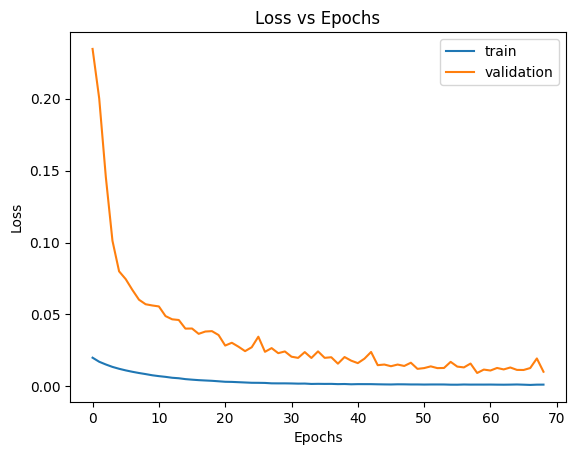

In [9]:
# plot the training and validation subgraphs loss

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()



# 6. Testing Predictions 

In [9]:
loaded_model = mlflow.keras.load_model("runs:/1e48dd4569d64fd3810231c99b2e1dd2/model")
print(loaded_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,607 (615.66 KB)

 Trainable params: 52,535 (205.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,072 (410.44 KB)

None


In [10]:
# evaluate the model
train_loss, train_mae = loaded_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = loaded_model.evaluate(X_test, y_test, verbose=0)

print(f"Train loss: {train_loss}, Train MAE: {train_mae}")

Train loss: 0.0011335068847984076, Train MAE: 0.01737266220152378


In [11]:
import numpy as np

# Dummy input for testing (matches input shape: timestep=30, features=8)
test_input = np.random.rand(1, 30, 2)  # Batch size=1, timestep=30, features=6

# Make a prediction
prediction = loaded_model.predict(test_input)
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Prediction: [[0.41663915 0.3961331  0.41203955 0.4140692  0.4115612  0.39831352
  0.42196208 0.40880966 0.41502514 0.4144141 ]]


In [12]:
# Load the preprocessed data
scaled_df = pd.read_csv("/home/abdullah/ai_workspace/project/Stock_prediction_project/initial_training/data/preprocessed_data/scaled_nvidia_stock.csv")

# load the scaler
scalar = joblib.load("/home/abdullah/ai_workspace/project/Stock_prediction_project/initial_training/notebooks/scaler.pkl")

# Load the model
model = mlflow.keras.load_model("runs:/1e48dd4569d64fd3810231c99b2e1dd2/model")

# denormalize the data
denormalized_data = scalar.inverse_transform(scaled_df[feature_cols].values)

print(denormalized_data.shape) # (2516, 4)
print(denormalized_data[2500][0]) # should be 

# Extract the last 30 rows for input to the LSTM model
timesteps = timestep
input_sequence = denormalized_data[-timesteps:]  # Shape: (timestep, features)

# Reshape to 3D: (1, timesteps, features)
input_sequence = input_sequence.reshape(1, timesteps, len(feature_cols))
print("Input shape for prediction:", input_sequence.shape)



(2515, 2)
136.05
Input shape for prediction: (1, 30, 2)


In [13]:
# Load the trained model
#model = mlflow.keras.load_model("runs:/d780c4c8034e453284081eb5d956f191/model")

# Make a prediction
prediction = model.predict(input_sequence)
print("Predicted Value:", prediction[0][0])

# Suppose the model predicts a scaled value, e.g. prediction = [[0.415...]]
# The scaler expects a shape (1, number_of_features)
# Have 5 features in the input sequence 
dummy_row = scaled_df[feature_cols].iloc[-1:].values.copy()  # Last row from the scaled DF
dummy_row[0, feature_cols.index(target_col)] = prediction[0][0]  # Insert predicted scaled value
denormalized_row = scalar.inverse_transform(dummy_row)
denormalized_prediction = denormalized_row[0, feature_cols.index(target_col)]
print("Denormalized Predicted Value:", denormalized_prediction)
print("Scaled Value:", scaled_df[target_col].iloc[-1])
print("Actual Value:", denormalized_data[-1][0]) # should be first value in stock price column

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predicted Value: 0.9131686
Denormalized Predicted Value: 135.99408266649246
Scaled Value: 0.9533023902707248
Actual Value: 141.95


In [14]:
# Predict n days into the future
n_days = forcast_days # Number of days to predict
future_predictions = []

current_sequence = input_sequence.copy()  # Start with the last 30 days

for _ in range(forcast_days):
    # Predict the next day
    next_pred = model.predict(current_sequence)[0, 0]
    future_predictions.append(next_pred)
    
    # Update the sequence: remove the oldest row and append the new prediction
    next_row = np.array([next_pred] * len(feature_cols))  # Replicate across features
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_row]], axis=1)

print("Future Predictions:", future_predictions)

# Denormalize the future predictions
# Create a placeholder array with the same number of features as scaler
future_pred_array = np.zeros((forcast_days, len(feature_cols)))
future_pred_array[:, feature_cols.index(target_col)] = future_predictions
denormalized_future_predictions = scalar.inverse_transform(future_pred_array)[:, feature_cols.index(target_col)]

print("Denormalized Future Predictions:", denormalized_future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Future Predictions: [np.float32(0.9131686), np.float32(0.9129034), np.float32(0.9122534), np.float32(0.911277), np.float32(0.9100766), np.float32(0.9087483), np.float32(0.9073683), np.float32(0.90599895), np.float32(0.9046758), np.float32(0.90340614)]
Denormalized Future Predictions: [135.99408267 135.95472937 135.85826117 135.71336427 135.53522626
 135.33810597 135.13330786 134.93009307 134.73373349 134.5453171 ]


In [15]:
model_path = "/home/abdullah/ai_workspace/project/Stock_prediction_project/shared_model/nvda_stock_model"
mlflow.keras.save_model(model, model_path)

2024/12/17 11:47:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
